<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12b_OutputGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12 - aside (b): Collecting output gradients while training
In continuing the implementation of the near-zero gradient explainer, I've realised that I should just extend the existing custom training loop to collect the gradients w.r.t. layer outputs. This makes everything so much simpler.

In [64]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout afef024
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at 775b7f8 Bug fixes
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 621 bytes | 124.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   775b7f8..afef024  main       -> origin/main
Updating 775b7f8..afef024
Fast-forward
 train_observability_toolkit.py | 13 ++++++++++++-
 1 file changed, 12 insertions(+), 1 deletion(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [2]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic Setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


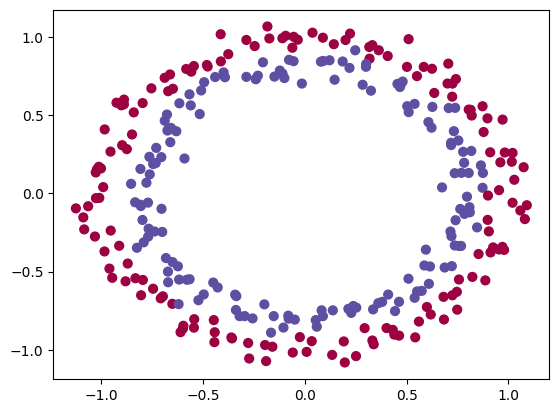

In [4]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [67]:
binary_classification_model('he_normal').summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)                    │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_240 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_241 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Collect and display data

In [65]:
# do training
reload(tot)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=[{}])

tf.config.run_functions_eagerly(False)
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
print(f"created: model_layers: {len(model.layers)}")
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=2, callbacks = [output_gradients])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

created: model_layers: 10
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7012

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.6977
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6863
Total training time: 3.39 secs


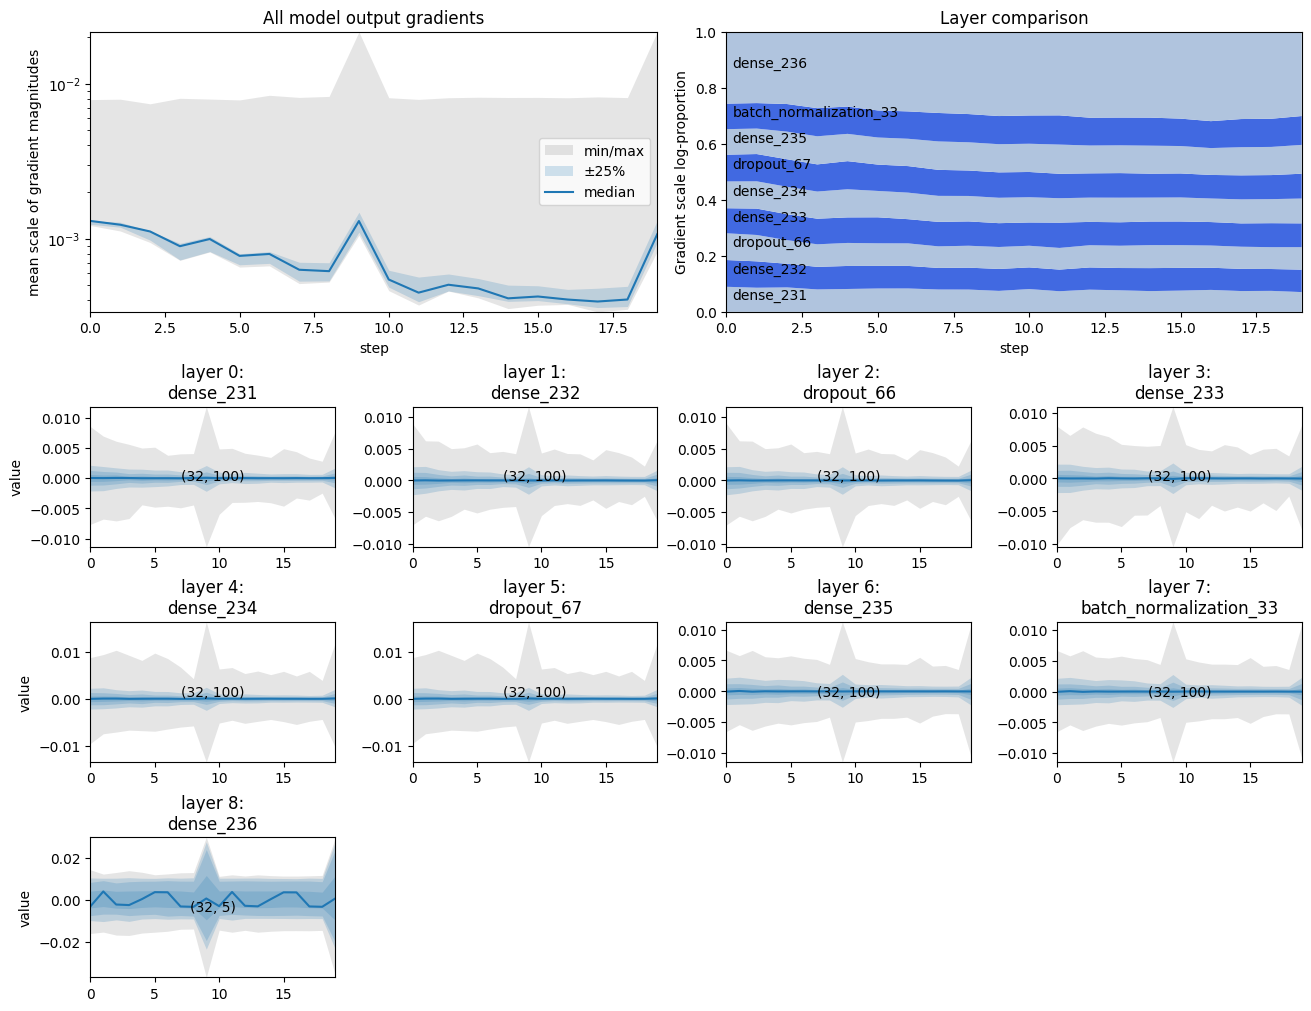

In [68]:
tot.plot_output_gradient_history(output_gradients)

In [70]:
print(f"gradients: len {len(output_gradients.gradients)} x {[len(g) if g is not None else 'None' for g in output_gradients.gradients]} x {[g[0].shape if g is not None else 'None' for g in output_gradients.gradients]}")

gradients: len 10 x [20, 20, 'None', 20, 20, 'None', 20, 20, 20, 'None'] x [TensorShape([32, 100]), TensorShape([32, 100]), 'None', TensorShape([32, 100]), TensorShape([32, 100]), 'None', TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 5]), 'None']
